In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import string
from nltk.corpus import stopwords
from sklearn.neighbors import NearestNeighbors
import re

%matplotlib inline

In [102]:
# settings to display all columns
pd.set_option("display.max_columns", None)
# display the dataframe head
df.head()

,review_rating,review_text
0,1,Love having the option of flexible dates. I wa...
1,0,Rebooking with credit due to Covid cancelled t...
2,1,Easy to follow and use even if your not tech s...
3,0,Was suppose to be able to cancel for 24 hours....
4,1,i waited over an hour on hold for 4 days last ...


In [112]:
df['string'] = df['review_text'].str.contains('bank')

<ipython-input-112-1e276a06f673>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['string'] = df['review_text'].str.contains('bank')


In [114]:
df['string'].value_counts()

False    494
True       6
Name: string, dtype: int64

In [3]:
df = pd.read_excel('data/flighthub_reviews.xlsx')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 24 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   query                                500 non-null    object 
 1   name                                 500 non-null    object 
 2   google_id                            500 non-null    object 
 3   place_id                             500 non-null    object 
 4   location_link                        500 non-null    object 
 5   reviews_link                         500 non-null    object 
 6   reviews_per_score                    500 non-null    object 
 7   rating                               500 non-null    float64
 8   review_id                            500 non-null    object 
 9   author_link                          500 non-null    object 
 10  author_title                         500 non-null    object 
 11  author_id                       

In [5]:
# drop unnecessary columns:

df = df[['author_title', 'review_text', 'review_rating']]

In [6]:
df.head()

,author_title,review_text,review_rating
0,Suzanne Hebert,Love having the option of flexible dates. I wa...,5
1,Richard Ho,Rebooking with credit due to Covid cancelled t...,1
2,Cindy Villeneuve,Easy to follow and use even if your not tech s...,5
3,Scott K-T,Was suppose to be able to cancel for 24 hours....,1
4,Victor Pare,i waited over an hour on hold for 4 days last ...,5


In [7]:
print(f'We have {df.shape[0]} rows and {df.shape[1]} columns of data')


We have 500 rows and 3 columns of data


In [8]:
# check for duplicates:

df['review_text'].value_counts

<bound method IndexOpsMixin.value_counts of 0      Love having the option of flexible dates. I wa...
1      Rebooking with credit due to Covid cancelled t...
2      Easy to follow and use even if your not tech s...
3      Was suppose to be able to cancel for 24 hours....
4      i waited over an hour on hold for 4 days last ...
                             ...                        
495    Worst customer service ever. they dont care ab...
496    Personally I enjoy this site, they always have...
497    i travel quiet often, and flight hub is my go ...
498    This is the first trip I have planned since 19...
499    Very easy to search and find great prices on f...
Name: review_text, Length: 500, dtype: object>

In [9]:
# check for nulls:
print(df.isna().sum())

author_title     0
review_text      0
review_rating    0
dtype: int64


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   author_title   500 non-null    object
 1   review_text    500 non-null    object
 2   review_rating  500 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 11.8+ KB


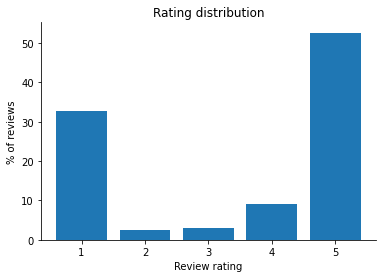

In [11]:
values, counts = np.unique(df['review_rating'], return_counts=True)
normalized_counts = counts/counts.sum()

plt.figure()
plt.bar(values, normalized_counts * 100)
plt.xlabel('Review rating')
plt.ylabel('% of reviews')
sns.despine()
plt.title("Rating distribution")
plt.show()

In [12]:
# value counts + total # of reviews
print(f'Review rating count for dataset: \n\
.......\n\
{df["review_rating"].value_counts()}')

print(f'Total number of unique reviews for dataset: \n\
.......\n\
{df["review_rating"].value_counts().sum()}')

Review rating count for dataset: 
.......
5    263
1    164
4     46
3     15
2     12
Name: review_rating, dtype: int64
Total number of unique reviews for dataset: 
.......
500


In [13]:
# review-text distribution
df['review_length'] = df['review_text'].map(len)

[Text(10.04999999999999, 0.5, 'Number of reviews')]

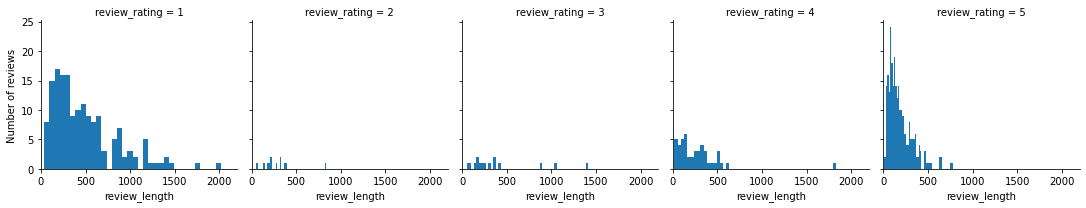

In [14]:
# Check how the review lenghts are distributed
ax = sns.FacetGrid(data=df, col='review_rating', xlim=(0,2200)).map(plt.hist, 'review_length', bins=50)
ax.axes[0][0].set(ylabel='Number of reviews')

In [15]:
# make new df with just 'rating' and 'text'

df = df[['review_rating', 'review_text']]
df.head(1)

,review_rating,review_text
0,5,Love having the option of flexible dates. I wa...


In [16]:
# Binarize 
# 0 = ratings 1,2,3 (negative)
# 1 = ratings 4,5 (positive)

# mtl
df['review_rating'] = np.where(df['review_rating'] >= 4, 1, 0)
df

<ipython-input-16-57516343dd81>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review_rating'] = np.where(df['review_rating'] >= 4, 1, 0)


,review_rating,review_text
0,1,Love having the option of flexible dates. I wa...
1,0,Rebooking with credit due to Covid cancelled t...
2,1,Easy to follow and use even if your not tech s...
3,0,Was suppose to be able to cancel for 24 hours....
4,1,i waited over an hour on hold for 4 days last ...
...,...,...
495,0,Worst customer service ever. they dont care ab...
496,1,"Personally I enjoy this site, they always have..."
497,1,"i travel quiet often, and flight hub is my go ..."
498,1,This is the first trip I have planned since 19...


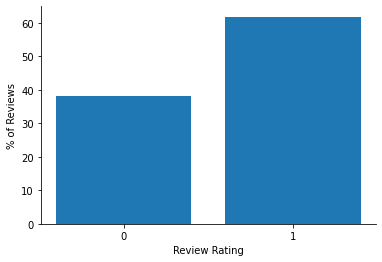

Class imbalance in dataset: [0.38 0.62]


In [17]:
# review rating distribution:

values, counts = np.unique(df['review_rating'], return_counts=True)
normalized_counts = counts/counts.sum()

plt.figure()
plt.bar(["0", "1"], normalized_counts*100) # plot normalized counts
plt.xlabel('Review Rating')
plt.ylabel('% of Reviews')
sns.despine()
plt.show()

print(f"Class imbalance in dataset: {np.round(normalized_counts, 2)}")

In [61]:
X = df['review_text']
y = df['review_rating']

In [64]:
from sklearn.feature_extraction.text import CountVectorizer

In [65]:
# 1. Instantiate 
bagofwords = CountVectorizer()

# 2. Fit 
bagofwords.fit(df["review_text"])

# 3. Transform
small_transformed = bagofwords.transform(df["review_text"])
small_transformed

<500x2522 sparse matrix of type '<class 'numpy.int64'>'
	with 19439 stored elements in Compressed Sparse Row format>

In [66]:
# these are now the features, they are the individual tokens
bagofwords.get_feature_names()

['00',
 '018',
 '10',
 '100',
 '1000',
 '10th',
 '11',
 '1175',
 '12',
 '121',
 '125',
 '12hrs',
 '13',
 '1300',
 '14',
 '140',
 '14th',
 '15',
 '1500',
 '155',
 '16',
 '16th',
 '1700',
 '18',
 '1800',
 '18hours',
 '18th',
 '19',
 '1985',
 '199',
 '19th',
 '1hr',
 '1st',
 '20',
 '200',
 '2000',
 '2015',
 '2016',
 '2017',
 '2019',
 '2020',
 '2021',
 '2022',
 '20th',
 '20x',
 '2100',
 '215',
 '218',
 '21st',
 '22',
 '235',
 '24',
 '24h',
 '24hours',
 '24hr',
 '24hrs',
 '25',
 '250',
 '2500',
 '259',
 '26',
 '26th',
 '28',
 '2hrs',
 '2nd',
 '30',
 '300',
 '3000',
 '30th',
 '31',
 '310',
 '32',
 '34',
 '35',
 '38',
 '3days',
 '3h',
 '3x',
 '40',
 '400',
 '4200',
 '430',
 '45',
 '450',
 '45m',
 '470',
 '48',
 '48h',
 '48hrs',
 '4th',
 '4x',
 '50',
 '500',
 '54',
 '56',
 '5635',
 '56626',
 '60',
 '600',
 '70',
 '72',
 '72h',
 '75',
 '772',
 '784',
 '80',
 '800',
 '820',
 '84',
 '850',
 '8m',
 '900',
 '940',
 '989',
 '99',
 '9x',
 'ability',
 'able',
 'about',
 'about1',
 'above',
 'abroad',


In [67]:
# converting the sparse matrix into a numpy array
small_transformed.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [68]:
# We can extract the information and put it in a data frame to make it easier to see what has occured
my_df = pd.DataFrame(columns=bagofwords.get_feature_names(), data=small_transformed.toarray())
display(my_df)

00  018  10  100  1000  10th  11  1175  12  121  125  12hrs  13  1300  \
0     0    0   0    0     0     0   0     0   0    0    0      0   0     0   
1     0    0   0    0     0     0   0     0   0    0    0      0   0     0   
2     0    0   0    0     0     0   0     0   0    0    0      0   0     0   
3     0    0   0    1     0     0   0     0   0    0    0      0   0     0   
4     0    0   0    0     0     0   0     0   0    0    0      0   0     0   
..   ..  ...  ..  ...   ...   ...  ..   ...  ..  ...  ...    ...  ..   ...   
495   0    0   0    0     0     0   0     0   0    0    0      0   0     0   
496   0    0   0    0     0     0   0     0   0    0    0      0   0     0   
497   0    0   0    0     0     0   0     0   0    0    0      0   0     0   
498   0    0   0    0     0     0   0     0   0    0    0      0   0     0   
499   0    0   0    0     0     0   0     0   0    0    0      0   0     0   

     14  140  14th  15  1500  155  16  16th  1700  18  1800  18hours  18th  \
0     0    0     0   0     0    0   0     0     0   0     0        0     0   
1     0    0     0   0     0    0   0     0     0   0     0        0     0   
2     0    0     0   0     0    0   0     0     0   0     0        0     0   
3     0    0     0   0     0    0   0     0     0   0     0        0     0   
4     0    0     0   0     0    0   0     0     0   0     0        0     0   
..   ..  ...   ...  ..   ...  ...  ..   ...   ...  ..   ...      ...   ...   
495   0    0     0   0     0    0   0     0     0   0     0        0     0   
496   0    0     0   0     0    0   0     0     0   0     0        0     0   
497   0    0     0   0     0    0   0     0     0   0     0        0     0   
498   0    0     0   0     0    0   0     0     0   0     0        0     0   
499   0    0     0   0     0    0   0     0     0   0     0        0     0   

     19  1985  199  19th  1hr  1st  20  200  2000  2015  2016  2017  2019  \
0     0     0    0     0    0    0   0    0     0     0     0     0     0   
1     0     0    0     0    0    0   0    0     0     0     0     0     0   
2     0     0    0     0    0    0   0    0     0     0     0     0     0   
3     0     0    0     0    0    0   0    0     0     0     0     0     0   
4     0     0    0     0    0    0   1    0     0     0     0     0     0   
..   ..   ...  ...   ...  ...  ...  ..  ...   ...   ...   ...   ...   ...   
495   0     0    0     0    0    0   0    0     0     0     0     0     0   
496   0     0    0     0    0    0   0    0     0     0     0     0     0   
497   0     0    0     0    0    0   0    0     0     0     0     0     0   
498   0     1    0     0    0    0   0    0     0     0     0     0     0   
499   0     0    0     0    0    0   0    0     0     0     0     0     0   

     2020  2021  2022  20th  20x  2100  215  218  21st  22  235  24  24h  \
0       0     0     0     0    0     0    0    0     0   0    0   0    0   
1       0     0     0     0    0     0    0    0     0   0    0   0    0   
2       0     0     0     0    0     0    0    0     0   0    0   0    0   
3       0     0     0     0    0     0    0    0     0   0    0   1    0   
4       0     0     0     0    0     0    0    0     0   0    0   0    0   
..    ...   ...   ...   ...  ...   ...  ...  ...   ...  ..  ...  ..  ...   
495     0     0     0     0    0     0    0    0     0   0    0   0    0   
496     0     0     0     0    0     0    0    0     0   0    0   0    0   
497     0     0     0     0    0     0    0    0     0   0    0   0    0   
498     0     0     0     0    0     0    0    0     0   0    0   0    0   
499     0     0     0     0    0     0    0    0     0   0    0   0    0   

     24hours  24hr  24hrs  25  250  2500  259  26  26th  28  2hrs  2nd  30  \
0          0     0      0   0    0     0    0   0     0   0     0    0   0   
1          0     0      0   0    0     0    0   0     0   0     0    0   0   
2          0     0      0   0    0     0    0   0     0   0

In [69]:
# splitting our data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [70]:
# size of training data
X_train.shape

(335,)

In [71]:
# 1. Instantiate
bagofwords = CountVectorizer()

# 2. Fit
bagofwords.fit(X_train)

# 3. Transform
X_train_transformed = bagofwords.transform(X_train)
X_train_transformed

<335x2051 sparse matrix of type '<class 'numpy.int64'>'
	with 12705 stored elements in Compressed Sparse Row format>

In [72]:
X_test_transformed = bagofwords.transform(X_test)
X_test_transformed

<165x2051 sparse matrix of type '<class 'numpy.int64'>'
	with 6199 stored elements in Compressed Sparse Row format>

In [74]:
words = bagofwords.get_feature_names()
some_indices = range(1, 2051, round(2051/10)) # just pick some indices

samples = [words[i] for i in some_indices]
print(samples)

['10', 'asia', 'come', 'earned', 'friends', 'invoice', 'near', 'protect', 'serous', 'tirelessly']


In [75]:
counts = np.array(X_train_transformed[:, some_indices].sum(axis = 0))

display(pd.DataFrame({"total_corpus_count": counts[0]}, index=samples).T)

,10,asia,come,earned,friends,invoice,near,protect,serous,tirelessly
total_corpus_count,15,1,7,3,9,1,2,1,1,1


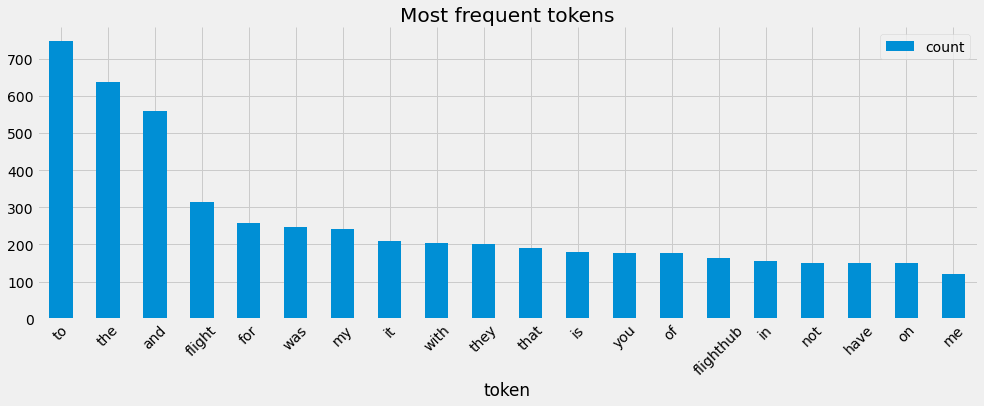

In [76]:
word_counts = X_train_transformed.toarray().sum(axis=0)

def plot_most_frequent(words, word_counts, top=20):
    words_df = pd.DataFrame({"token": words, 
                             "count": word_counts})
    
    fig, ax = plt.subplots(figsize=(0.75*top, 5))
    words_df.sort_values(by="count", ascending=False).head(top)\
        .set_index("token")\
        .plot(kind="bar", rot=45, ax=ax)
    sns.despine()
    plt.title("Most frequent tokens")
    plt.show()
    
plot_most_frequent(words, word_counts)

In [77]:
bagofwords = CountVectorizer(stop_words="english")
bagofwords.fit(X_train)

X_train_transformed = bagofwords.transform(X_train) 
X_test_transformed = bagofwords.transform(X_test) 

X_train_transformed.shape

(335, 1829)

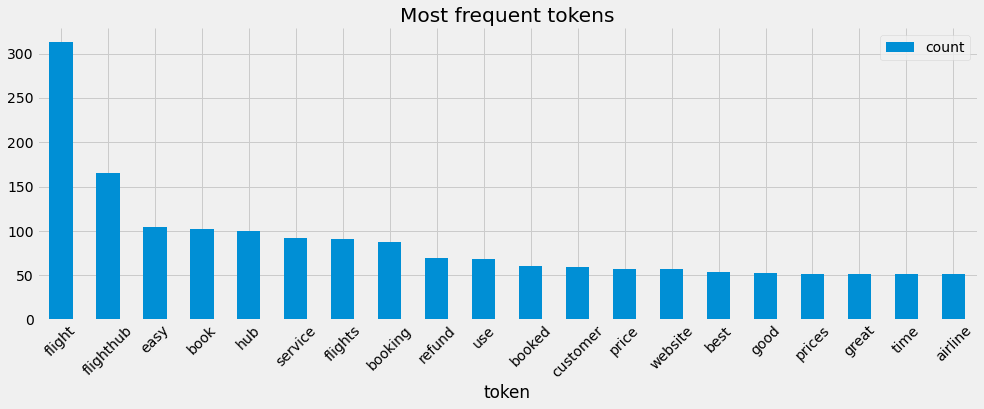

In [78]:
words = bagofwords.get_feature_names()
word_counts = X_train_transformed.toarray().sum(axis=0)

plot_most_frequent(words, word_counts)

In [79]:
# Fitting a model
logreg = LogisticRegression(C = 0.1)
logreg.fit(X_train_transformed, y_train)

# Training and test score
print(f"Train score: {logreg.score(X_train_transformed, y_train)}")
print(f"Test score: {logreg.score(X_test_transformed, y_test)}")

Train score: 0.9641791044776119
Test score: 0.8363636363636363


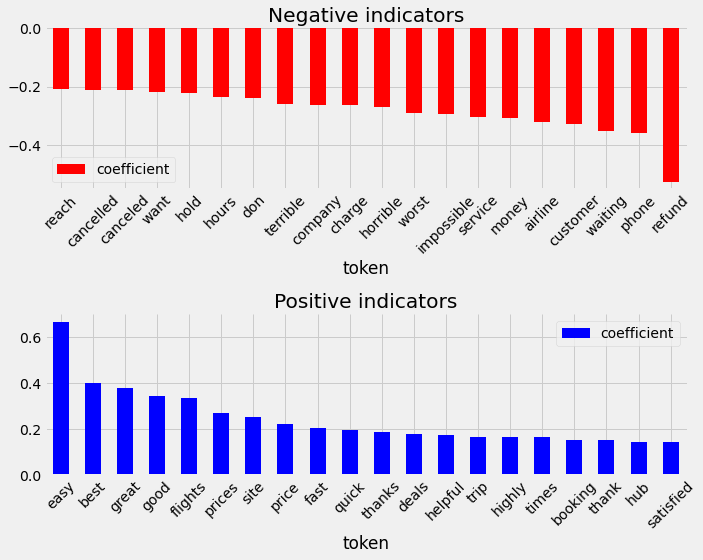

In [80]:
def plot_coefs(logreg, words):
    coef_df = pd.DataFrame({"coefficient": logreg.coef_[0], "token": words})
    coef_df = coef_df.sort_values("coefficient", ascending=False)

    fig, axs = plt.subplots(2, 1, figsize=(10, 8))

    # smallest coefficient -> tokens indicating negative sentiment 
    coef_df.tail(20).set_index("token").plot(kind="bar", rot=45, ax=axs[0], color="red")
    axs[0].set_title("Negative indicators")
 
    
    # largest coefficient -> tokens indicating positive sentiment 
    coef_df.head(20).set_index("token").plot(kind="bar", rot=45, ax=axs[1], color="blue")
    axs[1].set_title("Positive indicators")
    
    sns.despine()
    plt.tight_layout()
    plt.show()
    
plot_coefs(logreg, words)

In [81]:
bagofwords = CountVectorizer(stop_words="english", min_df=5)
bagofwords.fit(X_train)

X_train_transformed = bagofwords.transform(X_train)

X_train_transformed.shape

(335, 324)

In [82]:
bagofwords = CountVectorizer(stop_words="english",
                             min_df=5,
                             max_features=1000)
bagofwords.fit(X_train)

X_train_transformed = bagofwords.transform(X_train)

X_train_transformed.shape

(335, 324)

In [83]:
import nltk

# Let's test it out
stemmer = nltk.stem.PorterStemmer()

[stemmer.stem(i) for i in ['run', 'runs', 'running', 'ran', 'jogged', 'jogging', 'jogs']]

['run', 'run', 'run', 'ran', 'jog', 'jog', 'jog']

In [84]:
bagofwords = CountVectorizer(min_df=5, 
                             tokenizer = lambda x: [stemmer.stem(i) for i in x.split(' ')], 
                             stop_words='english')
bagofwords.fit(X_train)

X_train_transformed = bagofwords.transform(X_train)
X_test_transformed = bagofwords.transform(X_test)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'so

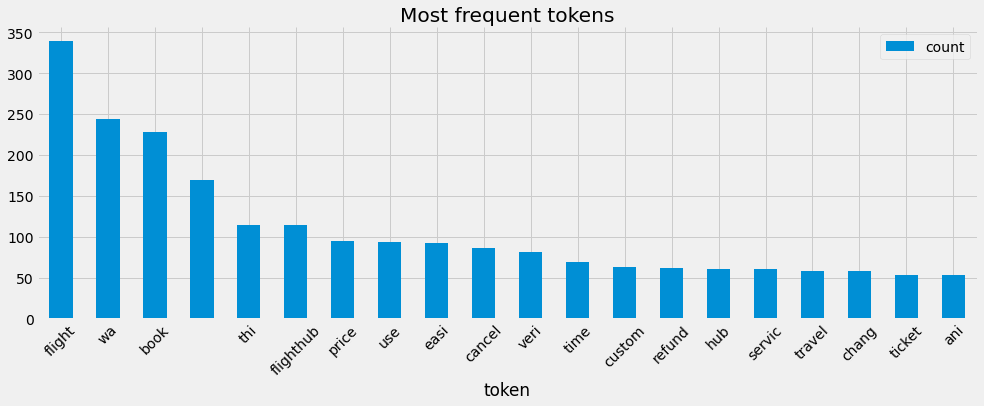

In [85]:
words = bagofwords.get_feature_names()
word_counts = X_train_transformed.toarray().sum(axis=0)

plot_most_frequent(words, word_counts)

In [87]:
# the python string package has a helpful punctuation list
import string
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [88]:
# a dummy sentence used for checking our process
sentence = "The quick brown fox, jumped over the lazy dog!!"

# after splitting the text based on spaces
split_sentence = sentence.split(' ')

# we stem and remove punctuation
tokenized_sentence = []
for word in split_sentence:
    for punctuation_mark in string.punctuation:
        word = word.replace(punctuation_mark, '')
    stemmed_word = stemmer.stem(word)
    tokenized_sentence.append(stemmed_word)
    
print(tokenized_sentence)

['the', 'quick', 'brown', 'fox', 'jump', 'over', 'the', 'lazi', 'dog']


In [89]:
# import the nltk stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords 

ENGLISH_STOP_WORDS = stopwords.words('english')

def my_tokenizer(sentence):
    # remove punctuation and set to lower case
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark,'').lower()

    # split sentence into words
    listofwords = sentence.split(' ')
    listofstemmed_words = []
    
    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in ENGLISH_STOP_WORDS) and (word!=''):
            # Stem words
            stemmed_word = stemmer.stem(word)
            listofstemmed_words.append(stemmed_word)

    return listofstemmed_words

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/d_anderson/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [90]:
# checking tokenizer on simple sentence from above
my_tokenizer(sentence)

['quick', 'brown', 'fox', 'jump', 'lazi', 'dog']

In [91]:
bagofwords = CountVectorizer(min_df=5, 
                             tokenizer=my_tokenizer)
bagofwords.fit(X_train)

X_train_transformed = bagofwords.transform(X_train)
X_test_transformed = bagofwords.transform(X_test)

X_train_transformed.shape

(335, 369)

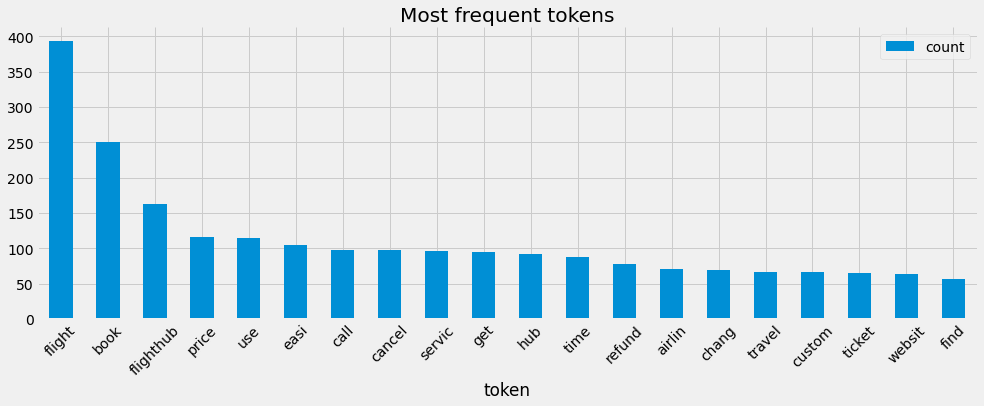

In [92]:
words = bagofwords.get_feature_names()
word_counts = X_train_transformed.toarray().sum(axis=0)

plot_most_frequent(words, word_counts)

In [93]:
# Fitting a model
logreg = LogisticRegression(C = 0.1)
logreg.fit(X_train_transformed, y_train)

# Training and test score
print(f"Train score: {logreg.score(X_train_transformed, y_train)}")
print(f"Test score: {logreg.score(X_test_transformed, y_test)}")

Train score: 0.9432835820895522
Test score: 0.8303030303030303


In [94]:
bagofwords = CountVectorizer(min_df=5,
                             tokenizer=my_tokenizer,
                             ngram_range=(1, 3))
bagofwords.fit(X_train)

X_train_transformed = bagofwords.transform(X_train)
X_test_transformed = bagofwords.transform(X_test)

X_train_transformed.shape

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


(335, 456)

In [95]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [98]:
# using our custom tokenizer in TfidfVectorizer
tfidf = TfidfVectorizer(min_df=5,
                        tokenizer=my_tokenizer)
tfidf.fit(X_train)

X_train_transformed = tfidf.transform(X_train)
X_test_transformed = tfidf.transform(X_test)

X_train_transformed.shape

(335, 369)

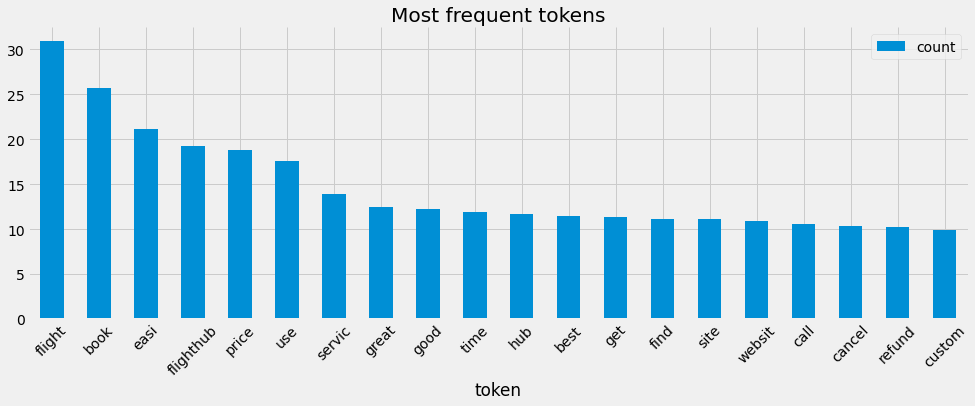

In [99]:
words = tfidf.get_feature_names()
word_weights = X_train_transformed.toarray().sum(axis=0)

plot_most_frequent(words, word_weights)

In [100]:
from sklearn.neighbors import NearestNeighbors

nn_model = NearestNeighbors(n_neighbors=1, metric="cosine")
nn_model.fit(X_train_transformed)

NearestNeighbors(metric='cosine', n_neighbors=1)

In [101]:
idx = 6
print(f"Selected test document:\n {X_test.iloc[idx]}")

# use the nearest neighbour model to find the closest document by the tf-idf representation
dist, neighbour_ind = nn_model.kneighbors(X_test_transformed[idx])

print(f"\nClosest training neighbour:\n {X_train.iloc[neighbour_ind[0]].values[0]}")

Selected test document:
 cheap flights and all in one location with multiple options. however, HORRIBLE customer service. can't find a number or an email to contact them. they provided an INVALID airline confirmation number which makes me wonder if i actually bought a ticket!! they took my money but it doesn't show up on the airline website....

Closest training neighbour:
 DID NOT GET MY ITINERARY IN MY E-MAIL, STILL WAITING.  NO ONE ANSWERS THE CUSTOMER SERVICE NUMBER


In [18]:
# sentiment polarity

from sklearn.feature_extraction.text import CountVectorizer
# store simplified data in X and y

X = df['review_text']
y = df['review_rating']

In [19]:
# create positive and negative review dfs

neg_reviews = np.where(df['review_rating']==0)

neg = df.iloc[neg_reviews]
neg

,review_rating,review_text
1,0,Rebooking with credit due to Covid cancelled t...
3,0,Was suppose to be able to cancel for 24 hours....
5,0,No customer service and zero responsibility. ...
6,0,I am really dissatisfied with FlightHub today....
7,0,It was the first time that we booked our fligh...
...,...,...
468,0,As with many travellers - we booked and paid t...
479,0,I purchased a ticket online from FlightHub for...
485,0,Worst customer service ever. they dont care ab...
489,0,Aircanada has processed my refund on may 14th ...


In [20]:
pos_reviews = np.where(df['review_rating']==1)

pos = df.iloc[pos_reviews]
pos

,review_rating,review_text
0,1,Love having the option of flexible dates. I wa...
2,1,Easy to follow and use even if your not tech s...
4,1,i waited over an hour on hold for 4 days last ...
9,1,just used flighthub for the first time and it ...
10,1,"Quite easy to to book, flight connections were..."
...,...,...
494,1,Easy to book. Best price I could find for the ...
496,1,"Personally I enjoy this site, they always have..."
497,1,"i travel quiet often, and flight hub is my go ..."
498,1,This is the first trip I have planned since 19...


In [21]:
neg_reviews = neg
pos_reviews = pos

In [22]:
# Convert to array
neg_reviews = neg_reviews[['review_text']].to_numpy()

In [23]:
# Convert to array
pos_reviews = pos_reviews[['review_text']].to_numpy()

In [24]:
neg_reviews = neg_reviews.flatten()


In [25]:
pos_reviews = pos_reviews.flatten()


In [26]:
from sklearn.feature_extraction import text


In [27]:
stop_words = text.ENGLISH_STOP_WORDS


In [28]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a vectorizer object to generate term document counts
tfidf_pos = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

tfidf_neg = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

# Get random subset of reviews
np.random.seed(38)
num_reviews = 2000
random_neg = np.random.choice(neg_reviews, size=num_reviews)
random_pos = np.random.choice(pos_reviews, size=num_reviews)

dicty = {'flights':'flight', 'prices':'price', 'travels':'travel',
         'layovers':'layover', 'services':'service'}
def replace_words(text, dicty):
    '''Returns text with word substitutions made according
       to the passed `dicty` dictionary'''
    for i,j in dicty.items():
        text = text.replace(i,j)
    return text

random_neg = [replace_words(w, dicty) for w in random_neg]
random_pos = [replace_words(w, dicty) for w in random_pos]

# Get the vectors
neg_vectors = tfidf_neg.fit_transform(random_neg)
pos_vectors = tfidf_pos.fit_transform(random_pos)

CPU times: user 134 ms, sys: 2.87 ms, total: 137 ms
Wall time: 137 ms


In [29]:
# Store TFIDF vectors in a df for later use
neg_df = pd.DataFrame(neg_vectors.todense(), columns=[tfidf_neg.get_feature_names()])
pos_df = pd.DataFrame(pos_vectors.todense(), columns=[tfidf_pos.get_feature_names()])

# get mean for each word
# high mean = important
col_means_neg = {}
for col in neg_df:
    col_means_neg[col] = neg_df[col].mean()

col_means_pos = {}
for col in pos_df:
    col_means_pos[col] = pos_df[col].mean()

In [30]:
no_top_words = 8

print('Top %d words in POSITIVE reviews:' %no_top_words, end='')
print(sorted(col_means_pos, key=col_means_pos.get, reverse=True)[:no_top_words])

print('Top %d words in NEGATIVE reviews:' %no_top_words, end='')
print(sorted(col_means_neg, key=col_means_neg.get, reverse=True)[:no_top_words])

Top 8 words in POSITIVE reviews:[('easy',), ('price',), ('flighthub',), ('best',), ('book',), ('great',), ('good',), ('booking',)]
Top 8 words in NEGATIVE reviews:[('refund',), ('service',), ('flighthub',), ('customer',), ('book',), ('hours',), ('ticket',), ('hub',)]


In [31]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.


In [32]:
# LSA
from gensim import corpora, models, similarities, matutils

# Convert to gensim corpus
# Transpose
tfidf_pos_corp = matutils.Sparse2Corpus(pos_vectors.transpose())
tfidf_neg_corp = matutils.Sparse2Corpus(neg_vectors.transpose())

# Row indices
id2word_pos = dict((v,k) for k,v in tfidf_pos.vocabulary_.items())
id2word_neg = dict((v,k) for k,v in tfidf_neg.vocabulary_.items())

id2word_pos = corpora.Dictionary.from_corpus(tfidf_pos_corp, id2word=id2word_pos)
id2word_neg = corpora.Dictionary.from_corpus(tfidf_neg_corp, id2word=id2word_neg)

In [33]:
# create LSA model
# LSA model
num_topics = 10
lsi_pos = models.LsiModel(tfidf_pos_corp, id2word=id2word_pos, num_topics=num_topics)
lsi_neg = models.LsiModel(tfidf_neg_corp, id2word=id2word_neg, num_topics=num_topics)

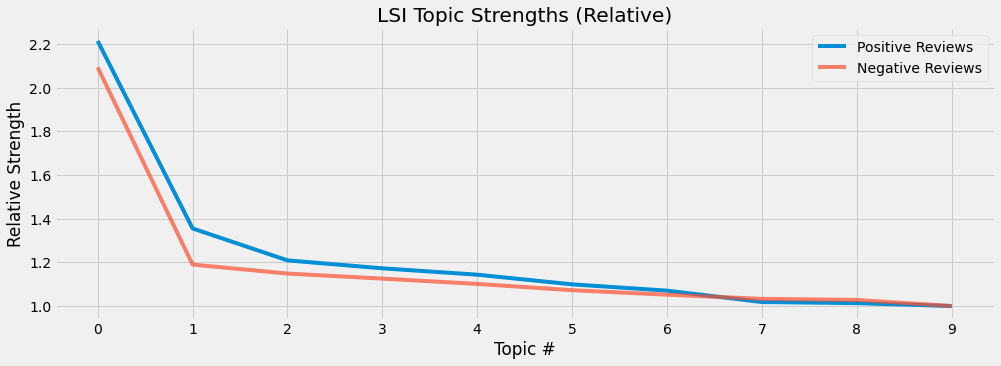

In [34]:
# elbow plot
singular_values_pos = lsi_pos.projection.s.tolist()
singular_values_pos_rel = [sv/singular_values_pos[-1] for sv in singular_values_pos]
singular_values_neg = lsi_neg.projection.s.tolist()
singular_values_neg_rel = [sv/singular_values_neg[-1] for sv in singular_values_neg]

plt.style.use('fivethirtyeight')
plt.figure(figsize=(15,5))
plt.plot(range(len(singular_values_pos)), singular_values_pos_rel, label='Positive Reviews', alpha=1.0)
plt.plot(range(len(singular_values_neg)), singular_values_neg_rel, label='Negative Reviews', alpha=0.7)
plt.xticks(range(len(singular_values_pos)), range(len(singular_values_pos)))
plt.xlabel('Topic #')
plt.ylabel('Relative Strength')
plt.title('LSI Topic Strengths (Relative)')
plt.legend(loc=0, fontsize='medium');

In [35]:
topics = 3

In [36]:
# check out top 5 positive topics
print('Top %d topics for POSITIVE reviews' %(topics))
print('-'*33)
print(lsi_pos.show_topics()[0:topics])

Top 3 topics for POSITIVE reviews
---------------------------------
[(0, '-0.336*"easy" + -0.305*"price" + -0.266*"flighthub" + -0.261*"book" + -0.245*"best" + -0.231*"great" + -0.230*"good" + -0.197*"use" + -0.193*"service" + -0.187*"booking"'), (1, '0.621*"good" + 0.498*"service" + -0.246*"best" + -0.206*"easy" + 0.203*"customer" + -0.179*"book" + 0.132*"quick" + 0.129*"professional" + -0.108*"use" + 0.084*"covid"'), (2, '0.514*"book" + 0.346*"good" + -0.235*"booking" + 0.231*"best" + 0.219*"easy" + -0.191*"use" + 0.179*"price" + -0.177*"flighthub" + -0.167*"great" + 0.145*"deals"')]


In [37]:
# check out top 5 negative topics
print('Top %d topics for NEGATIVE reviews' %(topics))
print('-'*33)
print(lsi_neg.show_topics()[0:topics])

Top 3 topics for NEGATIVE reviews
---------------------------------
[(0, '0.211*"refund" + 0.198*"service" + 0.195*"flighthub" + 0.177*"customer" + 0.155*"book" + 0.145*"ticket" + 0.144*"hours" + 0.134*"credit" + 0.134*"hub" + 0.130*"airline"'), (1, '-0.422*"refund" + 0.307*"service" + 0.283*"customer" + 0.216*"worst" + 0.178*"dont" + -0.155*"month" + -0.148*"hub" + 0.116*"impossible" + 0.113*"wait" + -0.104*"receive"'), (2, '0.349*"refund" + -0.218*"ticket" + 0.213*"service" + 0.203*"customer" + -0.186*"tried" + -0.171*"book" + -0.163*"change" + 0.155*"waiting" + -0.148*"booking" + 0.138*"worst"')]


In [38]:
%%time
# negative values in LSA topics are not working
# could have better luck with NMF
from sklearn.decomposition import NMF

# change num_topics
num_topics = 3

nmf_pos = NMF(n_components=num_topics)
W_pos = nmf_pos.fit_transform(pos_vectors)
H_pos = nmf_pos.components_

nmf_neg = NMF(n_components=num_topics)
W_neg = nmf_neg.fit_transform(neg_vectors)
H_neg = nmf_neg.components_

CPU times: user 850 ms, sys: 19.1 ms, total: 869 ms
Wall time: 157 ms


/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


In [39]:
def display_topics(model, feature_names, num_topics, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        if topic_idx < num_topics:
            print("{:11}".format("Topic %d:" %(topic_idx)), end='')
            print(", ".join(['{:04.3f}*'.format(topic[i])+feature_names[i] \
                             for i in topic.argsort()[:-no_top_words-1:-1]]))

no_topics = num_topics
no_top_words = 6

print('Top topics + words for POSITIVE reviews')
print('-'*39)
display_topics(nmf_pos, tfidf_pos.get_feature_names(), no_topics, no_top_words)

print('\nTop topics + words for NEGATIVE reviews')
print('-'*39)
display_topics(nmf_neg, tfidf_neg.get_feature_names(), no_topics, no_top_words)

Top topics + words for POSITIVE reviews
---------------------------------------
Topic 0:   1.133*flighthub, 1.018*great, 1.011*use, 0.935*booking, 0.771*easy, 0.540*experience
Topic 1:   1.793*good, 1.428*service, 0.603*customer, 0.468*price, 0.379*professional, 0.352*quick
Topic 2:   1.415*book, 1.322*best, 0.900*easy, 0.846*price, 0.556*deals, 0.320*website

Top topics + words for NEGATIVE reviews
---------------------------------------
Topic 0:   0.739*flighthub, 0.708*book, 0.606*credit, 0.588*ticket, 0.559*change, 0.528*airline
Topic 1:   0.986*service, 0.914*customer, 0.666*worst, 0.503*dont, 0.315*care, 0.282*horrible
Topic 2:   1.434*refund, 0.505*hub, 0.503*waiting, 0.349*said, 0.324*told, 0.320*process


In [40]:
# look at a random positive review
review_num = np.random.randint(0, high=len(random_pos))
print(review_num)
print(random_pos[review_num])

108
FlightHub was easy to use, all costs are in CDN dollars. Found a great deal for my trip. They provide you all your travelling details in one quick location. Will use again!


In [41]:
# compute cosine similarities of this review wiht the rest
import sklearn.metrics.pairwise as smp

cosines = {}
for ind, review in enumerate(W_pos):
    similarity = smp.cosine_similarity(W_pos[review_num].reshape(1,-1), review.reshape(1,-1))
    cosines[ind] = similarity[0][0]

In [42]:
# get top 3 matching reviews
for n in sorted(cosines, key=cosines.get, reverse=True)[1:4]:
    print('-'*50)
    print('>> Similarity {:.3f}'.format(cosines[n]))
    print(random_pos[n])
print('-'*50)

--------------------------------------------------
>> Similarity 1.000
The reason I’m giving 4 stars and not 5 is because if you cancel it’s a hassle trying to go through the airlines directly for either your refund (which 9x out of 10 you don’t get) OR your flight credit. However, other than that I love it !
--------------------------------------------------
>> Similarity 1.000
I travel a lot and have tried to use other booking sights but I always come back to FlightHub to actually complete my booking. They constantly have the better rates and options. Even during the Pandemic, they went above and beyond to work with me to get my flight, rebooked or cancelled and refunds given (and the refund was in 48Hrs!) I've been booking exclusively through them for over 7 years! Never a problem.
--------------------------------------------------
>> Similarity 1.000
Great site to use. I've been extremely pleased with how easy it is to navigate and they do all the shopping for me. Love this site! I

In [43]:

# Create a vectorizer object to generate term document counts
cv_pos = CountVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

cv_neg = CountVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

# Get random subset of reviews
np.random.seed(38)
num_reviews = 15000
cv_random_neg = np.random.choice(neg_reviews, size=num_reviews)
cv_random_pos = np.random.choice(pos_reviews, size=num_reviews)

# replace words from defined dictionary 'dicty'
cv_random_neg = [replace_words(w, dicty) for w in cv_random_neg]
cv_random_pos = [replace_words(w, dicty) for w in cv_random_pos]

# Get the cv vectors
cv_neg_vectors = cv_neg.fit_transform(cv_random_neg).transpose()
cv_pos_vectors = cv_pos.fit_transform(cv_random_pos).transpose()

In [44]:
# Convert sparse matrix of counts to a gensim corpus
corpus_neg = matutils.Sparse2Corpus(cv_neg_vectors)
corpus_pos = matutils.Sparse2Corpus(cv_pos_vectors)

# save a mapping (dict) of row id to word (token) for later use by gensim 
id2word_cv_pos = dict((v, k) for k, v in cv_pos.vocabulary_.items())
id2word_cv_neg = dict((v, k) for k, v in cv_neg.vocabulary_.items())

In [45]:
%%time
# create lda multicore model
lda_pos = models.ldamulticore.LdaMulticore(corpus=corpus_pos, num_topics=5, 
                                           id2word=id2word_cv_pos, passes=10, workers=15)
lda_neg = models.ldamulticore.LdaMulticore(corpus=corpus_neg, num_topics=5, 
                                           id2word=id2word_cv_neg, passes=10, workers=15)

CPU times: user 37.4 s, sys: 1.9 s, total: 39.3 s
Wall time: 44.8 s


In [46]:
print('Top topics + words for POSITIVE reviews')
print('-'*39)
print(lda_pos.print_topics(num_words=7))

print('\nTop topics + words for NEGATIVE reviews')
print('-'*39)
print(lda_neg.print_topics(num_words=7))

Top topics + words for POSITIVE reviews
---------------------------------------
[(0, '0.036*"price" + 0.025*"flighthub" + 0.023*"good" + 0.021*"booking" + 0.017*"service" + 0.016*"best" + 0.015*"website"'), (1, '0.032*"easy" + 0.030*"flighthub" + 0.023*"price" + 0.023*"use" + 0.019*"service" + 0.016*"website" + 0.016*"best"'), (2, '0.045*"easy" + 0.039*"flighthub" + 0.030*"book" + 0.025*"price" + 0.022*"great" + 0.021*"website" + 0.020*"site"'), (3, '0.039*"flighthub" + 0.028*"booking" + 0.026*"easy" + 0.026*"price" + 0.024*"best" + 0.021*"hub" + 0.019*"use"'), (4, '0.024*"price" + 0.024*"book" + 0.023*"hub" + 0.021*"times" + 0.017*"able" + 0.017*"easy" + 0.016*"recommend"')]

Top topics + words for NEGATIVE reviews
---------------------------------------
[(0, '0.019*"airline" + 0.018*"book" + 0.013*"hub" + 0.012*"flighthub" + 0.010*"price" + 0.010*"agent" + 0.010*"booking"'), (1, '0.021*"flighthub" + 0.016*"book" + 0.014*"hub" + 0.012*"credit" + 0.011*"agent" + 0.010*"use" + 0.010*"co

In [47]:
# let's double check the positive topics
print('Top topics + words for POSITIVE reviews')
print('-'*39)
display_topics(nmf_pos, tfidf_pos.get_feature_names(), no_topics, no_top_words)

Top topics + words for POSITIVE reviews
---------------------------------------
Topic 0:   1.133*flighthub, 1.018*great, 1.011*use, 0.935*booking, 0.771*easy, 0.540*experience
Topic 1:   1.793*good, 1.428*service, 0.603*customer, 0.468*price, 0.379*professional, 0.352*quick
Topic 2:   1.415*book, 1.322*best, 0.900*easy, 0.846*price, 0.556*deals, 0.320*website


In [48]:
# let's look at a random positive review and see the topic distribution of the review
review_num = np.random.randint(0, high=len(random_pos))
print('Positive Review #%d' %review_num)
print('-'*25)
print(random_pos[review_num])
print('-'*25)
topic_dict = {}
for ind, w in enumerate(W_pos[review_num]):
    topic_dict[ind] = w
for k in sorted(topic_dict, key=topic_dict.get, reverse=True):
     print('Topic {}: {:.4f}'.format(k, topic_dict[k]))

Positive Review #1711
-------------------------
Google Flights was having issues for me and I’ve been trying to book a flight for the past few days. FlightHub responded instantly and was very well priced and organized. Thank you ✈️ ❤️
-------------------------
Topic 0: 0.0339
Topic 2: 0.0297
Topic 1: 0.0049


In [49]:
print('Top topics + words for NEGATIVE reviews')
print('-'*39)
display_topics(nmf_neg, tfidf_neg.get_feature_names(), no_topics, no_top_words)


Top topics + words for NEGATIVE reviews
---------------------------------------
Topic 0:   0.739*flighthub, 0.708*book, 0.606*credit, 0.588*ticket, 0.559*change, 0.528*airline
Topic 1:   0.986*service, 0.914*customer, 0.666*worst, 0.503*dont, 0.315*care, 0.282*horrible
Topic 2:   1.434*refund, 0.505*hub, 0.503*waiting, 0.349*said, 0.324*told, 0.320*process


In [50]:
# now let's look at a random negative review and see the topic distribution of the review
review_num = np.random.randint(0, high=len(random_neg))
print('Negative Review #%d' %review_num)
print('-'*25)
print(random_neg[review_num])
print('-'*25)
topic_dict = {}
for ind, w in enumerate(W_neg[review_num]):
    topic_dict[ind] = w
for k in sorted(topic_dict, key=topic_dict.get, reverse=True):
     print('Topic {}: {:.4f}'.format(k, topic_dict[k]))

Negative Review #151
-------------------------
I tried to correct a name 15 minutes after booking they wanted to charge me $35. plus I got the run around, not very satisfied at all.
-------------------------
Topic 0: 0.0597
Topic 1: 0.0000
Topic 2: 0.0000


In [51]:
print('Postive Reviews:  {:,}'.format(len(pos_reviews)))
print('Negative Reviews:  {:,}'.format(len(neg_reviews)))

Postive Reviews:  309
Negative Reviews:  191


In [123]:
pip install gensim

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Note: you may need to restart the kernel to use updated packages.


In [125]:
# Visualize the topics

import pyLDAvis
import pyLDAvis.gensim_models

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [129]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_pos, corpus_pos, corpus_pos)
vis

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AttributeError: 'Sparse2Corpus' object has no attribute 'token2id'

In [52]:
%%time
# Create a vectorizer object to generate term document counts
tfidf_pos = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

tfidf_neg = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

# replace words 
pos_reviews = [replace_words(w, dicty) for w in pos_reviews]
neg_reviews = [replace_words(w, dicty) for w in neg_reviews]

# Get the vectors
neg_vectors = tfidf_neg.fit_transform(neg_reviews)
pos_vectors = tfidf_pos.fit_transform(pos_reviews)

CPU times: user 25.9 ms, sys: 3.59 ms, total: 29.5 ms
Wall time: 27.7 ms


In [53]:
%%time
# NMF for all reviews
from sklearn.decomposition import NMF

# change num_topics
num_topics = 3

nmf_pos = NMF(n_components=num_topics)
W_pos = nmf_pos.fit_transform(pos_vectors)
H_pos = nmf_pos.components_

nmf_neg = NMF(n_components=num_topics)
W_neg = nmf_neg.fit_transform(neg_vectors)
H_neg = nmf_neg.components_

CPU times: user 256 ms, sys: 10.2 ms, total: 266 ms
Wall time: 50.2 ms


/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


In [54]:
no_topics = num_topics
no_top_words = 6

print('Topics for POSITIVE reviews')
print('-'*39)
display_topics(nmf_pos, tfidf_pos.get_feature_names(), no_topics, no_top_words)

print('\nTopics for NEGATIVE reviews')
print('-'*39)
display_topics(nmf_neg, tfidf_neg.get_feature_names(), no_topics, no_top_words)

Topics for POSITIVE reviews
---------------------------------------
Topic 0:   0.944*price, 0.940*best, 0.936*flighthub, 0.702*booking, 0.462*recommend, 0.410*experience
Topic 1:   1.177*easy, 0.815*use, 0.480*book, 0.476*great, 0.319*site, 0.286*thank
Topic 2:   0.952*service, 0.817*good, 0.562*hub, 0.439*customer, 0.268*covid, 0.247*got

Topics for NEGATIVE reviews
---------------------------------------
Topic 0:   0.670*flighthub, 0.551*book, 0.451*airline, 0.427*ticket, 0.408*money, 0.387*booking
Topic 1:   0.928*service, 0.874*customer, 0.474*worst, 0.249*use, 0.190*hours, 0.165*waiting
Topic 2:   1.255*refund, 0.431*hub, 0.412*waiting, 0.269*called, 0.258*process, 0.256*told


In [55]:
# create topic dictionaries
pos_topics = {0:'Product', 1:'Experience', 2:'Service'}

neg_topics = {0:'Product', 1:'Service', 2:'Experience'}

In [57]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
df['']